In [1]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_wide_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [3]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [4]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=.1, sigma=.1)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=2, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=1)
    beta_H = pm.Normal("beta_H", mu=1, sigma=1)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=1, sigma=1)
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = pm.Normal("alpha_L", mu=3, sigma=1)
    alpha_1 = pm.Normal("alpha_1", mu=3, sigma=1)
    alpha_2 = pm.Normal("alpha_2", mu=3, sigma=1)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)

    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [5]:
error_mean

0.13874934099513656

In [6]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000, chains=4) # chains=6 would still use 4 cores

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 881 seconds.
There were 8060 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [7]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 2MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     alpha_1  (chain, draw) float64 192kB 3.545 4.234 3.079 ... 4.286 4.287 4.287
     alpha_2  (chain, draw) float64 192kB -1.326 -1.846 -2.165 ... 2.42 2.42
     alpha_L  (chain, draw) float64 192kB 2.258 2.434 3.499 ... -3.0 -3.0 -3.0
     beta_H   (chain, draw) float64 192kB 0.7487 0.7432 0.805 ... 0.7174 0.7174
     beta_H2  (chain, draw) float64 192kB 0.392 0.3645 0.2464 ... 1.054 1.055
     beta_L   (chain, draw) float64 192kB 1.022 0.9943 1.049 ... 0.974 0.9741
     eta      (chain, draw) float64 192kB 0.06928 0.05364 ... 0.3018 0.3018
     rho      (chain, draw) float64 192kB 81.09 94.96 138.3 ... 15.22 15.22 15.22
     sigma    (chain, draw) float64 192kB 0.0846 0.08275 ... 0.08372 0.08372
 Attributes:
     created_at:                 2024-09-06T04:42

In [8]:
idata.posterior.data_vars

Data variables:
    alpha_1  (chain, draw) float64 192kB 3.545 4.234 3.079 ... 4.286 4.287 4.287
    alpha_2  (chain, draw) float64 192kB -1.326 -1.846 -2.165 ... 2.42 2.42
    alpha_L  (chain, draw) float64 192kB 2.258 2.434 3.499 ... -3.0 -3.0 -3.0
    beta_H   (chain, draw) float64 192kB 0.7487 0.7432 0.805 ... 0.7174 0.7174
    beta_H2  (chain, draw) float64 192kB 0.392 0.3645 0.2464 ... 1.054 1.055
    beta_L   (chain, draw) float64 192kB 1.022 0.9943 1.049 ... 0.974 0.9741
    eta      (chain, draw) float64 192kB 0.06928 0.05364 ... 0.3018 0.3018
    rho      (chain, draw) float64 192kB 81.09 94.96 138.3 ... 15.22 15.22 15.22
    sigma    (chain, draw) float64 192kB 0.0846 0.08275 ... 0.08372 0.08372

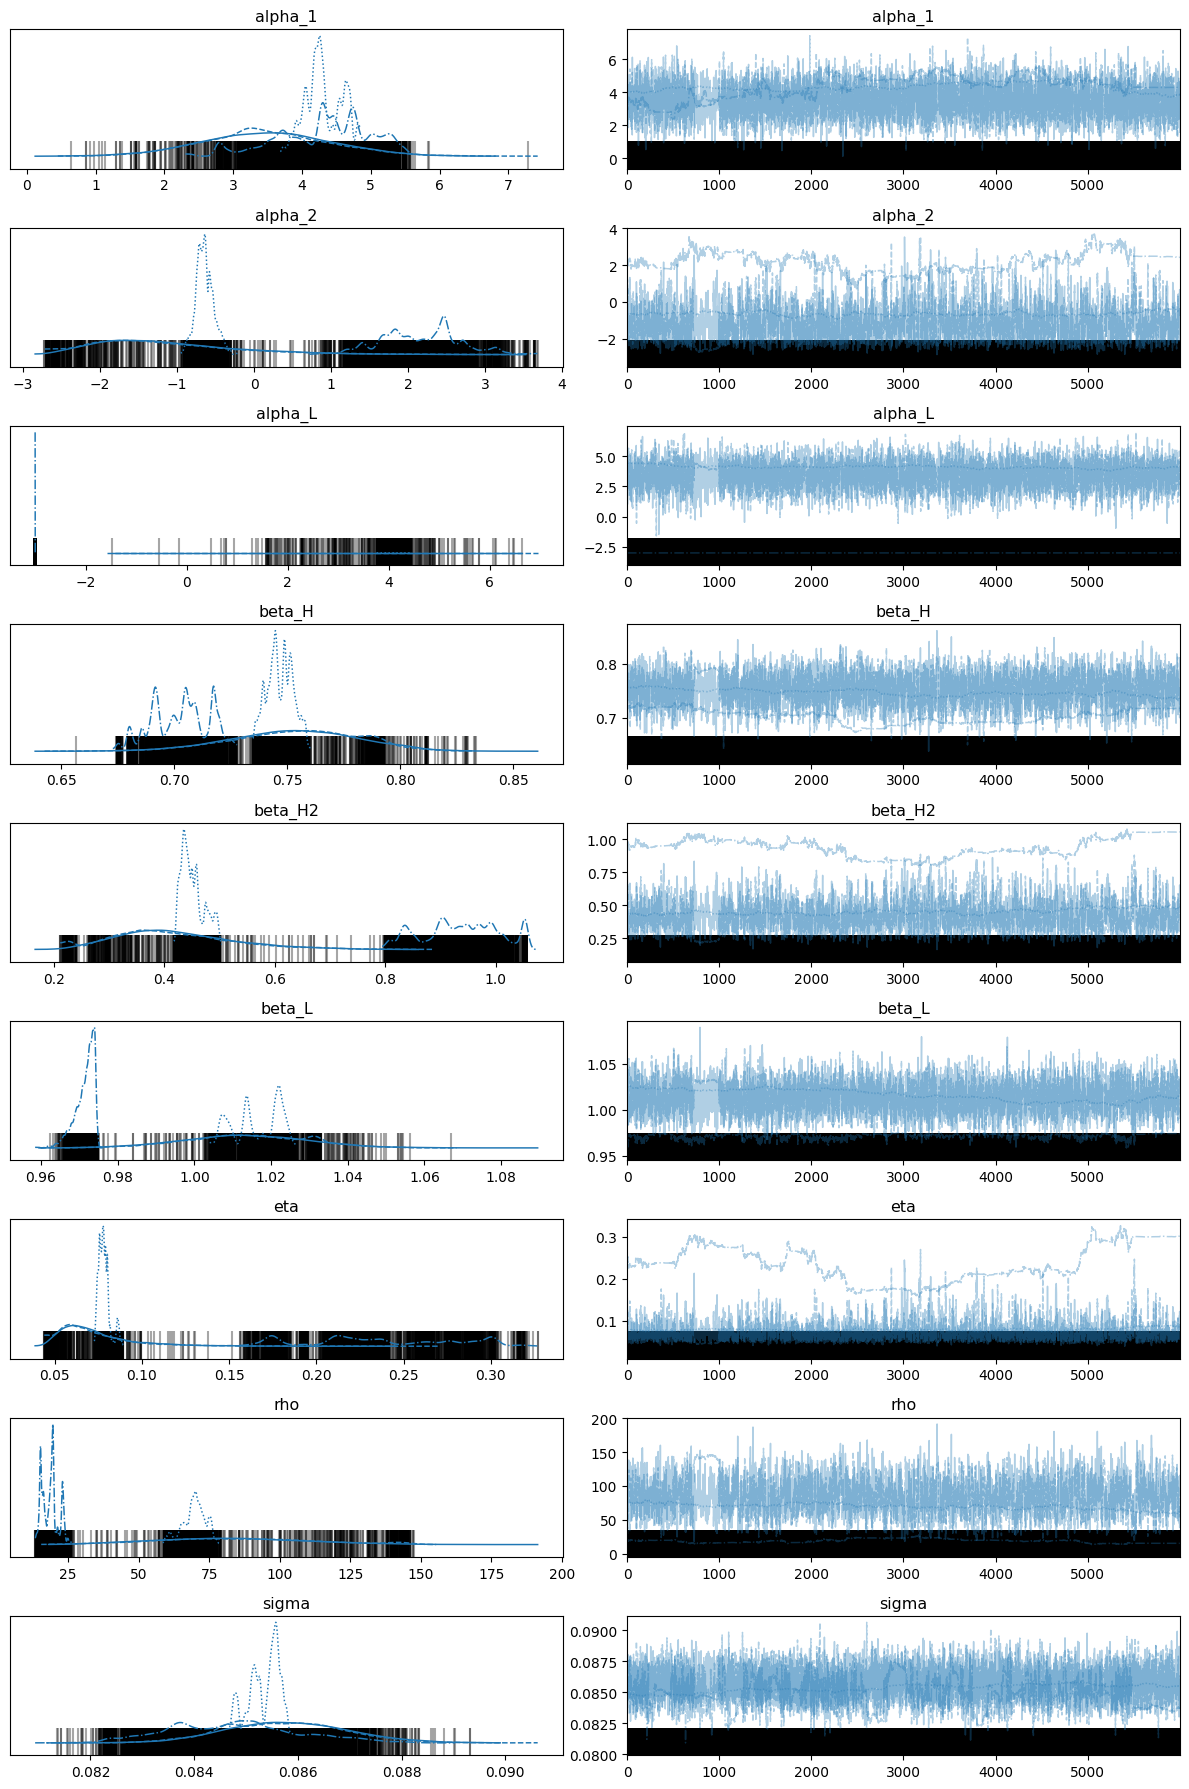

In [9]:
az.plot_trace(idata)
plt.tight_layout()

In [10]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
posterior_beta_H2 = idata["posterior"]["beta_H2"]
credible_interval_beta_H2 = np.percentile(posterior_beta_H2, [16, 50, 84])
posterior_alpha_L = idata["posterior"]["alpha_L"]
credible_interval_alpha_L = np.percentile(posterior_alpha_L, [16, 50, 84])
posterior_alpha_1 = idata["posterior"]["alpha_1"]
credible_interval_alpha_1 = np.percentile(posterior_alpha_1, [16, 50, 84])
posterior_alpha_2 = idata["posterior"]["alpha_2"]
credible_interval_alpha_2 = np.percentile(posterior_alpha_2, [16, 50, 84])
posterior_sigma = idata["posterior"]["sigma"]
credible_interval_sigma = np.percentile(posterior_sigma, [16, 50, 84])

print('eta',credible_interval_eta)
print('rho',credible_interval_rho)
print('beta_L',credible_interval_beta_L)
print('beta_H',credible_interval_beta_H)
print('beta_H2',credible_interval_beta_H2)
print('alpha_L',credible_interval_alpha_L)
print('alpha_1',credible_interval_alpha_1)
print('alpha_2',credible_interval_alpha_2)
print('sigma',credible_interval_sigma)




eta [0.06026027 0.07831881 0.21589467]
rho [19.61110003 68.98167182 96.0818394 ]
beta_L [0.9728173  1.0092983  1.02359203]
beta_H [0.7051325  0.74357097 0.76821248]
beta_H2 [0.36037578 0.45713517 0.90950715]
alpha_L [-2.99997643  3.43538181  4.18403069]
alpha_1 [2.98771627 4.06969542 4.69391694]
alpha_2 [-1.69902783 -0.64694164  1.94906249]
sigma [0.08441674 0.08540603 0.08648544]


In [11]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,3.904,0.867,2.197,5.394,0.237,0.171,13.763,114.837,1.197
alpha_2,-0.195,1.554,-2.329,2.741,0.696,0.524,6.501,44.205,2.036
alpha_L,1.979,2.985,-3.000,4.622,1.448,1.103,6.729,26.003,1.590
beta_H,0.739,0.030,0.685,0.794,0.011,0.008,8.076,34.991,1.423
beta_H2,0.558,0.236,0.266,1.018,0.110,0.086,6.633,19.212,1.858
beta_L,1.004,0.022,0.966,1.034,0.010,0.007,6.806,32.206,1.617
eta,0.115,0.075,0.044,0.277,0.035,0.027,6.551,17.394,2.023
rho,64.080,33.153,13.648,117.278,13.594,10.128,6.543,17.013,1.630
sigma,0.085,0.001,0.083,0.088,0.000,0.000,26.648,84.487,1.177


In [12]:
posterior_eta.values.flatten()

array([0.06927854, 0.05364373, 0.05202571, ..., 0.30174221, 0.30176189,
       0.30177033])

In [13]:
# Alternative method to find mode using histogram
def get_histogram_mode(data, bins=500):
    hist, bin_edges = np.histogram(data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    mode = bin_centers[np.argmax(hist)]
    return mode

# Extracting modes using histogram method for comparison
hist_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_histogram_mode(samples)
    hist_modes[var] = mode

print("Histogram modes of each posterior:")
for var, mode in hist_modes.items():
    print(f"{var}: {mode}")

Histogram modes of each posterior:
alpha_1: 4.293533618312672
alpha_2: -0.6356175299446143
alpha_L: -2.9900448152661014
beta_H: 0.7172891844549231
beta_H2: 0.43577679103230105
beta_L: 0.9740902402196601
eta: 0.07747410073024956
rho: 19.583424798225206
sigma: 0.08555663858605993


In [14]:
from scipy.stats import gaussian_kde

# Assuming `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Function to compute the mode using KDE
def get_mode_kde(data):
    kde = gaussian_kde(data)
    x_grid = np.linspace(min(data), max(data), 1000)
    mode = x_grid[np.argmax(kde(x_grid))]
    return mode

# Extracting modes for each parameter using KDE
kde_modes = {}
for var in idata.posterior.data_vars:
    samples = idata.posterior[var].values.flatten()
    mode = get_mode_kde(samples)
    kde_modes[var] = mode

print("KDE modes of each posterior:")
for var, mode in kde_modes.items():
    print(f"{var}: {mode}")


KDE modes of each posterior:
alpha_1: 4.253760644936148
alpha_2: -0.6595555106180209
alpha_L: 4.0353643793442
beta_H: 0.7470128223379361
beta_H2: 0.44425882893759117
beta_L: 0.9721365087057965
eta: 0.07462637665879324
rho: 70.42409945483271
sigma: 0.085532118218906


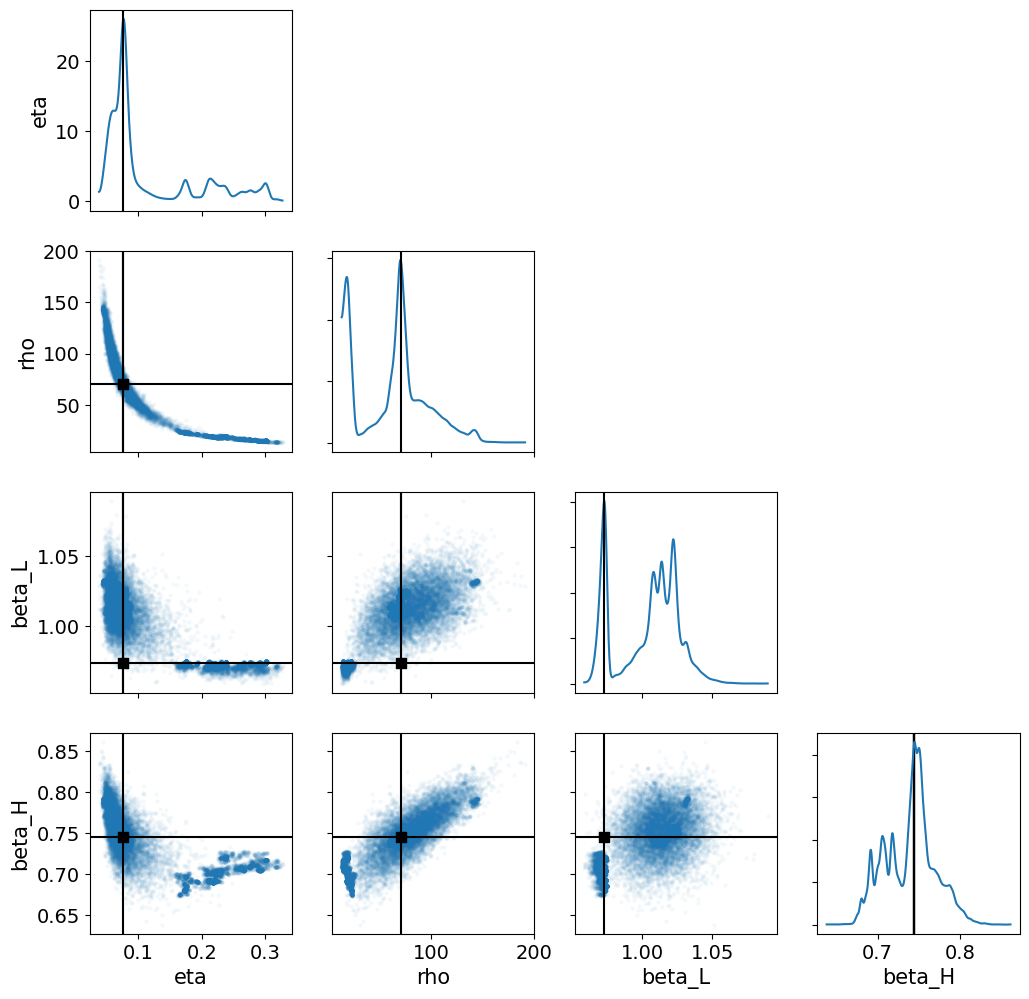

In [15]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="mode",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [16]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import gaussian_kde
import arviz as az  # Assume idata is an ArviZ InferenceData object

# Assume `idata` is your InferenceData object with posterior samples
posterior_samples = idata.posterior

# Define a function to evaluate the joint density using KDE
def joint_kde_density(point, samples):
    kde = gaussian_kde(samples.T)  # Transpose for proper shape
    return -kde(point)  # Negative because we are minimizing

# Extract the samples of all four parameters of interest
param_names = ['rho', 'eta', 'beta_L', 'beta_H', 'beta_H2', 'alpha_L', 'alpha_1', 'alpha_2']  # Replace with actual parameter names
sample_arrays = [posterior_samples[param].values.flatten() for param in param_names]

# Combine samples into a 2D array for joint distribution
joint_samples = np.vstack(sample_arrays).T

# Initial guess for the optimizer (mean of samples can be a good starting point)
initial_guess = np.mean(joint_samples, axis=0)

# Perform the optimization to find the mode
result = minimize(joint_kde_density, initial_guess, args=(joint_samples,), method='L-BFGS-B')

# The result contains the mode of the joint distribution
global_mode = result.x

# Print the global mode of the joint distribution
print(f"Global mode of the joint distribution ({', '.join(param_names)}): {global_mode}")

Global mode of the joint distribution (rho, eta, beta_L, beta_H, beta_H2, alpha_L, alpha_1, alpha_2): [72.61626108  0.07760843  1.02209658  0.75181636  0.43804565  4.16626976
  4.20430755 -0.62122679]


In [17]:
# define the error function 2 param modes
def error_function(n_LF, n_HF):
    eta = 11.20294568777112
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = 34422.595850790254
    beta_L = 1.1406839520015446
    beta_H = 4.145389781446169
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = 2.713544143928366
    # alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_L = 7.8176404049598816
    alpha_1 = 18.553167013696203
    alpha_2 = 7.5153891398955235

    sigma_lg_Phi = 0.21450697746101002   # standard deviation of the log of the error function
    # return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))
    lg_Phi = np.log10(eta) + np.log10(rho / ( (n_LF + n_HF) * (n_LF + alpha_L)**(beta_L-1) * (n_HF + alpha_1)**(beta_H-1) ) + 1 / (alpha_2 + n_HF)**(beta_H2))
    
    mode_Phi = 10**lg_Phi * np.exp(-sigma_lg_Phi**2 * (np.log(10))**2)
    mean_Phi = 10**lg_Phi * np.exp(1/2 * (sigma_lg_Phi * np.log(10))**2)
    median_Phi = 10**lg_Phi
    return median_Phi

In [18]:
# loss  mean
lg_phi = np.log10(error_function(n_LF, n_HF))
loss = np.mean((lg_phi - np.log(rel_error))**2)

In [19]:
loss

0.6449679782898841